In [15]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [6]:
import sys
sys.path.append("/home/ubuntu/bin/autoencoders")

from dataloader import MNISTDataLoader, DataLoaderConfig
from autoencoder import AutoEncoder, ModelConfig

In [8]:
config = DataLoaderConfig(batch_size=16, num_workers=4)
dataloader = MNISTDataLoader(config)
_, test_loader = dataloader.get_data_loaders()

INFO:dataloader:Initialized MNISTDataLoader with config: DataLoaderConfig(batch_size=16, num_workers=4, train_data=True, shuffle_train=True, shuffle_test=False, data_root='./data', image_size=32, normalize_mean=0.5, normalize_std=0.5, download=True)
INFO:dataloader:Data directory ensured at: ./data
INFO:dataloader:Loading MNIST datasets...
INFO:dataloader:Loaded 60000 training samples and 10000 test samples
INFO:dataloader:Created data loaders - Train batches: 3750, Test batches: 625


In [12]:
test_images = next(iter(test_loader))[0]
print(test_images.shape)

torch.Size([16, 1, 32, 32])


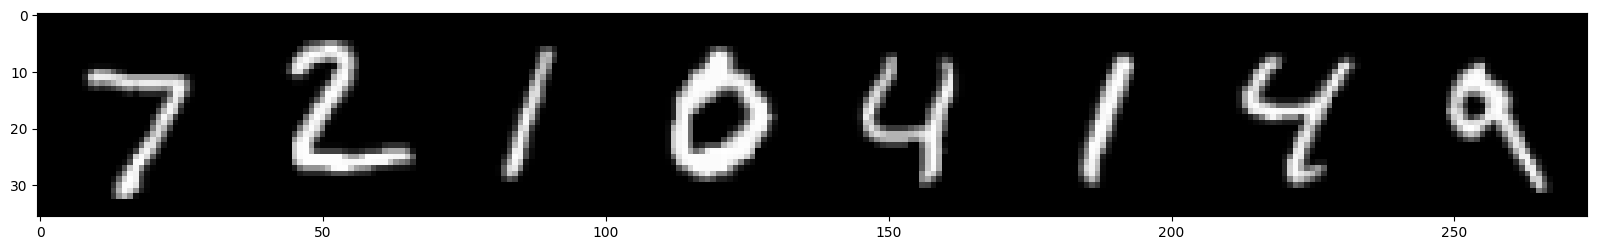

In [13]:
# Ground Truth Images:
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

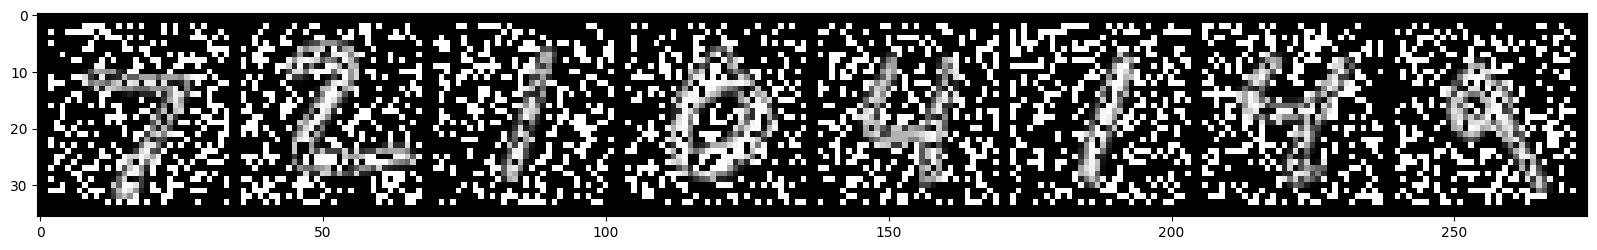

In [16]:
# Noisy Images:
noise_level = 0.3
test_images = next(iter(test_loader))[0]
plt.figure(figsize = (20,10))
noise = (torch.bernoulli((1 - noise_level) * torch.ones_like(test_images)) * 2) - 1
noisy_images = test_images * noise

out = vutils.make_grid(noisy_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [30]:
# Load the trained model:
import autoencoder as model_ae
sys.modules['model_ae'] = model_ae  

model_config = ModelConfig(feat_dim=32, latent_dim=128, channels=1)
ae = AutoEncoder(model_config)

checkpoint = torch.load(
    "/home/ubuntu/bin/autoencoders/logs/autoencoder_final.pth", 
    map_location='cpu', 
    weights_only=False
)
ae.load_state_dict(checkpoint['model_state_dict'])

print(f"Model has {sum(p.numel() for p in ae.parameters())} parameters")

ae.eval()

Model has 719969 parameters


AutoEncoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_out): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  )
  (decoder): Decoder(
    (conv1): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

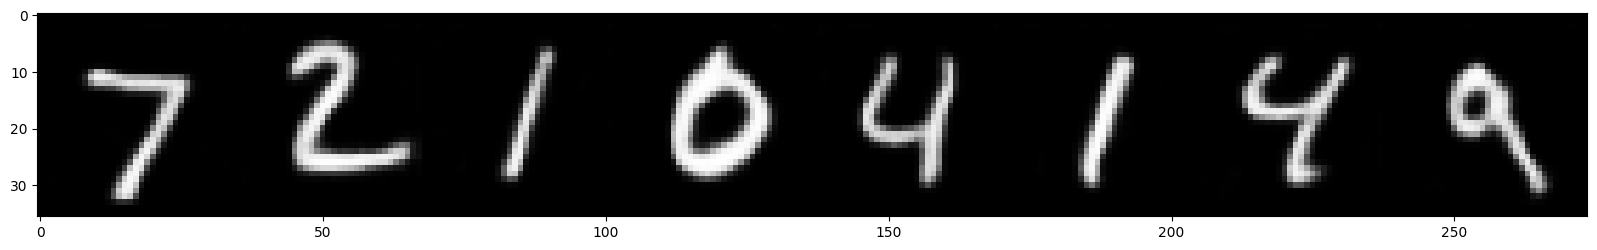

In [39]:
# Reconstruction of the noisy images:
recon_images, encoded_data = ae(noisy_images)

plt.figure(figsize = (20,10))
out = vutils.make_grid(recon_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

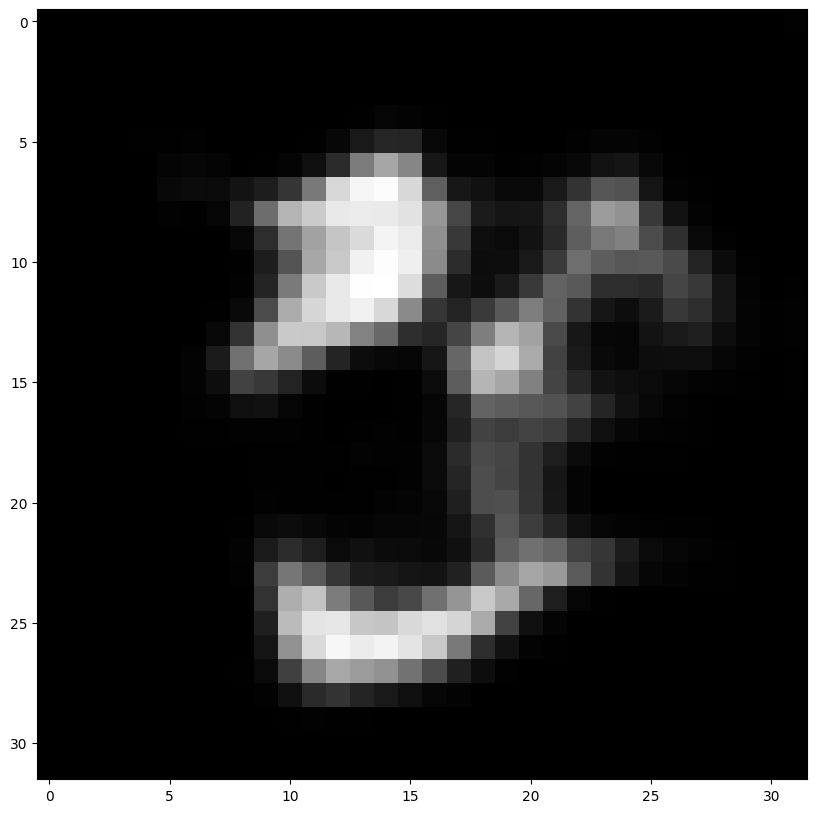

In [40]:
# Reconstruction of the noisy images:
recon_data = ae.decoder(
    encoded_data.std(0, keepdim=True) * torch.randn_like(encoded_data.std(0, keepdim=True)) + 
    encoded_data.mean(0, keepdim=True))
plt.figure(figsize = (20,10))
out = vutils.make_grid(recon_data[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))